# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #3

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [4]:
import tempfile
from copy import deepcopy

from code_analysis import CFG, CFGReader, Graph
from graphviz import Source
from IPython.display import Image
from ptfa import DefinitelyReachablePTFA, DefinitelyReachingPTFA, PatternCheck

%load_ext pyinstrument

cfg_reader = CFGReader()


def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))


def show_in_out(cfg: CFG, in_dict: dict[int, bool], out_dict: dict[int, bool]) -> CFG:
    """Annote un CFG avec les valeurs de in et out pour chaque noeud puis l'affiche"""
    cfg_copy = deepcopy(cfg)
    for nid in cfg_copy.get_node_ids():
        cfg_copy.set_image(
            nid,
            f"in={in_dict[nid]} out={out_dict[nid]} {cfg_copy.get_image(nid) or ''}",
        )
    show_graph(cfg_copy)
    return cfg_copy

## 1. Implémentation de PTFA

Nous avons choisi d'implémenter **Definitely Reachable PTFA** et **Definitely Reaching PTFA** dans le fichier [ptfa.py](ptfa.py).

**Definitely Reachable PTFA** sera utile pour fopen-fclose afin de vérifier si **tous les chemins** qui contiennent fopen sont **suivis** d'un fclose.

**Definitely Reaching PTFA** sera utile quant à lui pour vérifier si les appels de base de données sont **précédés** dans **tous les chemins** par une vérification de privilège.

Nous utilisons pyinstrument pour mesurer le temps d'exécution de ces algorithmes.

Lecture des CFGs :

In [143]:
cfg1 = cfg_reader.read_cfg("../tp/perf/graph1.cfg.json")
cfg2 = cfg_reader.read_cfg("../tp/perf/graph2.cfg.json")
cfg3 = cfg_reader.read_cfg("../tp/perf/graph3.cfg.json")
cfg4 = cfg_reader.read_cfg("../tp/perf/graph4.cfg.json")

On définit les algorithmes Definitely Reachable PTFA et Definitely Reaching PTFA pour la recherche des noeuds de type "Pattern" :

In [144]:
check: PatternCheck = lambda cfg, nid: cfg.get_type(nid) == "Pattern"  # noqa: E731
reachable_ptfa = DefinitelyReachablePTFA(check)
reaching_ptfa = DefinitelyReachingPTFA(check)

On applique Definitely Reachable PTFA au 1er CFG :

In [145]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reachable_ptfa(cfg1)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:00  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.001     CPU time: 0.001
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.001 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/1735832309.py:1
`- 0.001 DefinitelyReachablePTFA.__call__  ptfa.py:40
   |- 0.000 DefinitelyReachablePTFA.next_nodes  ptfa.py:83
   |  |- 0.000 [self]  ptfa.py
   |  `- 0.000 CFG.get_any_parents  code_analysis/CFG.py:40
   |     `- 0.000 CFG.get_parents  code_analysis/Graph.py:49
   |        `- 0.000 dict.get  <built-in>
   |- 0.000 DefinitelyReachablePTFA.pre_loop_init  ptfa.py:73
   |  `- 0.000 DefinitelyReachablePTFA.get_exit_node  ptfa.py:67
   |- 0.000 [self]  ptfa.py
   |- 0.000 DefinitelyReachablePTFA.can_propagate  ptfa.py:86
   `- 0.000 list.append  <built-in>

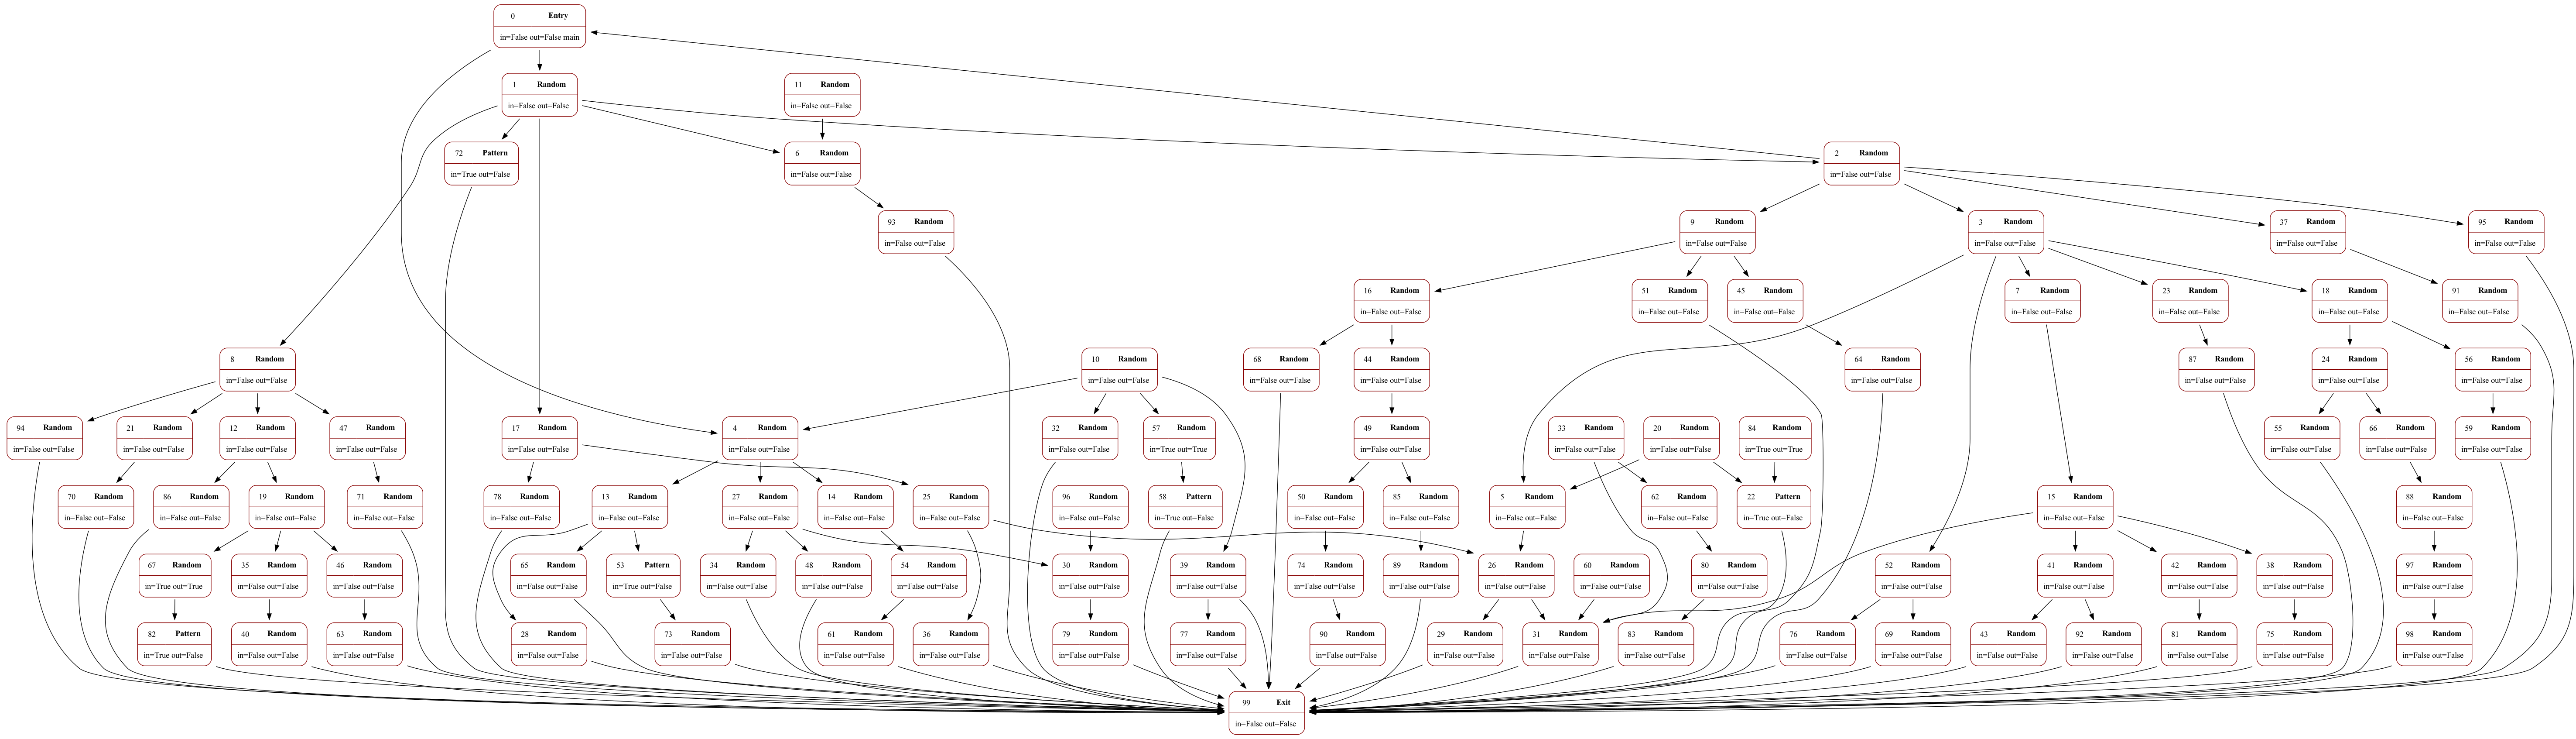

In [146]:
show_in_out(cfg1, in_dict, out_dict)  # type: ignore # noqa: F821

Le graphe est simple et ne pose aucune difficulté pour notre implémentation. Le résultat est instantané.

On fait de même avec Definitely Reaching PTFA :

In [147]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reaching_ptfa(cfg1)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:01  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.001     CPU time: 0.001
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.001 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/3071474652.py:1
`- 0.001 DefinitelyReachingPTFA.__call__  ptfa.py:40
   |- 0.000 DefinitelyReachingPTFA.next_nodes  ptfa.py:110
   |  `- 0.000 CFG.get_any_children  code_analysis/CFG.py:34
   |     |- 0.000 CFG.get_children  code_analysis/Graph.py:44
   |     `- 0.000 [self]  code_analysis/CFG.py
   |- 0.000 DefinitelyReachingPTFA.pre_loop_init  ptfa.py:100
   |  `- 0.000 DefinitelyReachingPTFA.get_entry_node  ptfa.py:94
   |     `- 0.000 CFG.get_type  code_analysis/Graph.py:23
   |- 0.000 DefinitelyReachingPTFA.can_propagate  ptfa.py:113
   |- 0.000 [self]  ptfa.py
   `- 0.000 DefinitelyReachingPTFA.check_node  ptfa.py:107
      `- 0.000 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
         `- 0.000 CFG.get_type  code_analysis/Graph.py:23

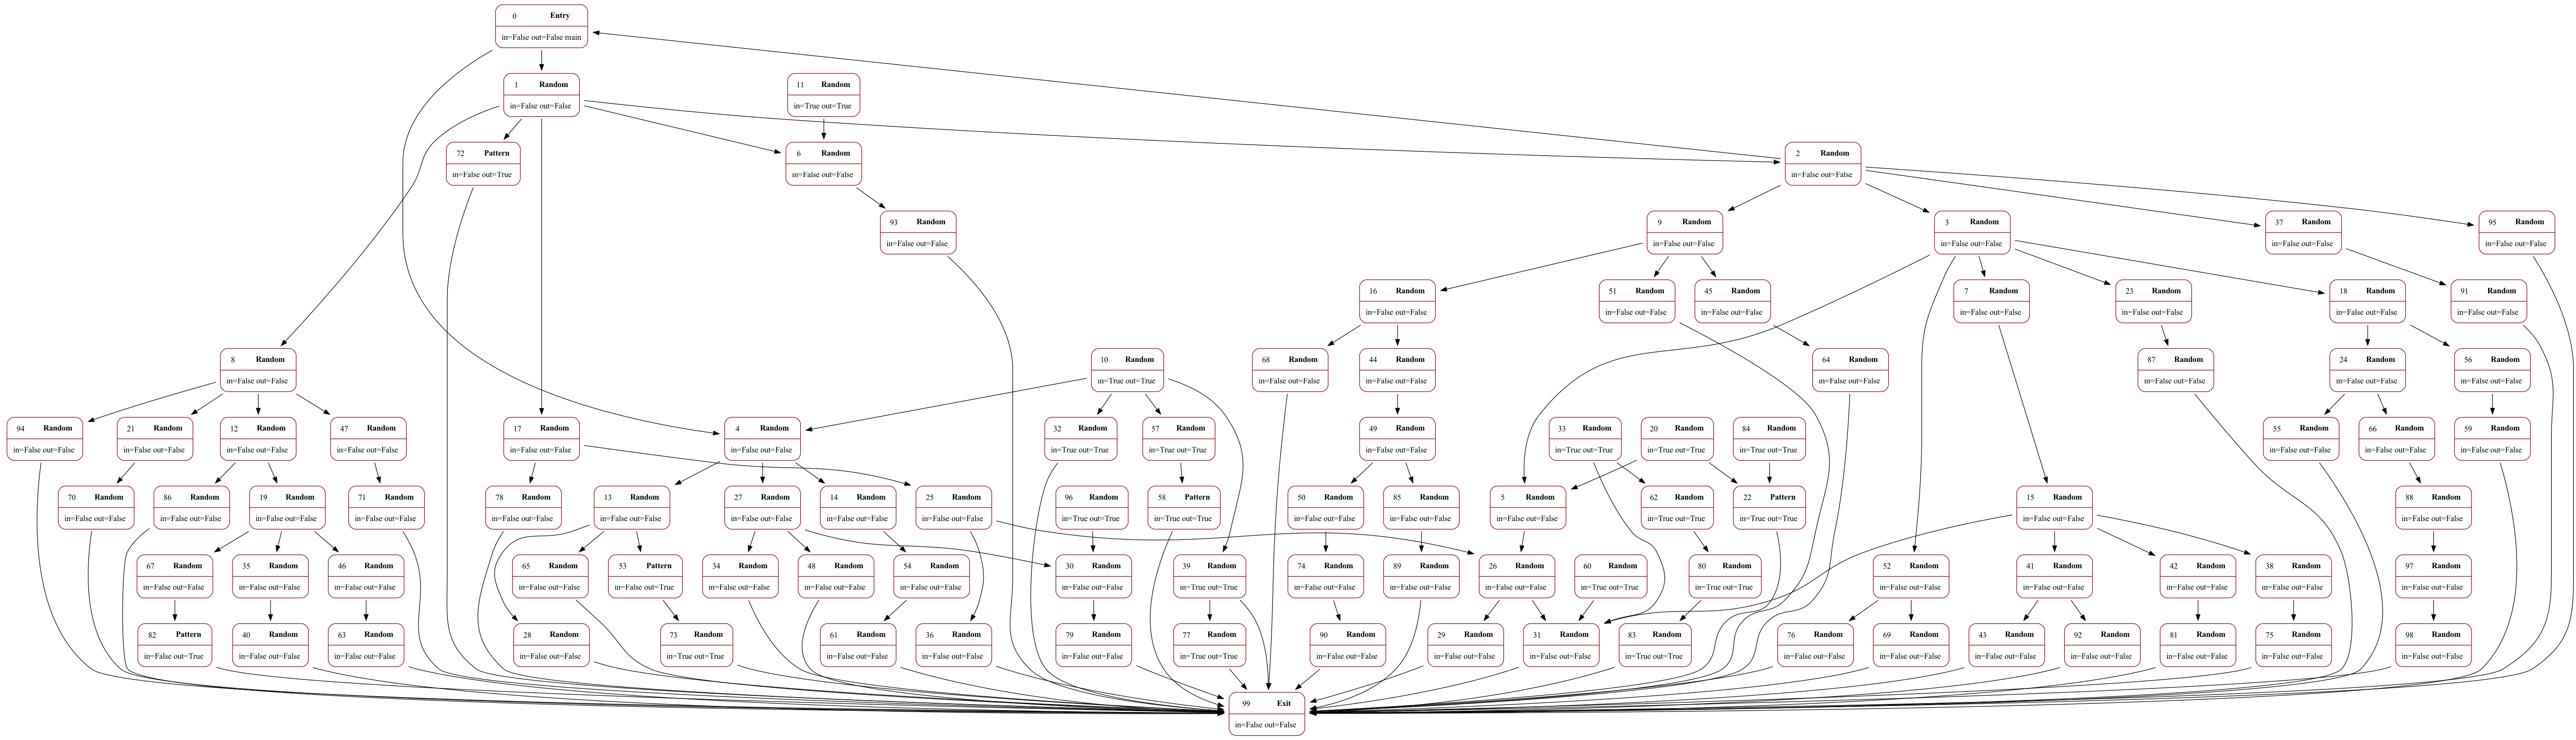

In [148]:
show_in_out(cfg1, in_dict, out_dict)  # type: ignore # noqa: F821

Même constat, le résultat est instantané.

Dans les deux cas, pyinstrument mesure 6 échantillons pour ~250 noeuds.

On passe maintenant au 2e CFG, toujours très rapide :

In [149]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reachable_ptfa(cfg2)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:01  Samples:  60
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.007     CPU time: 0.007
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.007 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/175091642.py:1
|- 0.006 DefinitelyReachablePTFA.__call__  ptfa.py:40
|  |- 0.002 DefinitelyReachablePTFA.next_nodes  ptfa.py:83
|  |  |- 0.002 CFG.get_any_parents  code_analysis/CFG.py:40
|  |  |  |- 0.001 CFG.get_parents  code_analysis/Graph.py:49
|  |  |  |  |- 0.000 dict.get  <built-in>
|  |  |  |  `- 0.000 [self]  code_analysis/Graph.py
|  |  |  |- 0.000 [self]  code_analysis/CFG.py
|  |  |  `- 0.000 list.copy  <built-in>
|  |  `- 0.000 [self]  ptfa.py
|  |- 0.002 [self]  ptfa.py
|  |- 0.001 DefinitelyReachablePTFA.check_node  ptfa.py:80
|  |  `- 0.001 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
|  |     |- 0.001 CFG.get_type  code_analysis/Graph.py:23
|  |     |  |- 0.001 [self]  code_analysis/Graph.py
|  |     |  `- 0.000 dict.get  <built-in>
|  |     `- 0.000 [self]  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py
|  |- 0.000 DefinitelyReachablePTFA.pre_loop_init  ptfa.py:73
|  |  `- 0.000 DefinitelyReachablePTFA.get_exit_node  ptfa.py:67
|  |     |- 0.000 [self]  ptfa.py
|  |     `- 0.000 CFG.get_type  code_analysis/Graph.py:23
|  |        `- 0.000 dict.get  <built-in>
|  |- 0.000 DefinitelyReachablePTFA.propagate  ptfa.py:89
|  |- 0.000 list.append  <built-in>
|  |- 0.000 DefinitelyReachablePTFA.can_propagate  ptfa.py:86
|  |- 0.000 CFG.get_node_ids  code_analysis/Graph.py:20
|  `- 0.000 list.pop  <built-in>
`- 0.000 Profiler.stop  pyinstrument/profiler.py:138

In [150]:
# show_in_out(cfg2, in_dict, out_dict)  # type: ignore # noqa: F821

In [151]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reaching_ptfa(cfg2)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:01  Samples:  54
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.006     CPU time: 0.006
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.006 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/935048700.py:1
`- 0.006 DefinitelyReachingPTFA.__call__  ptfa.py:40
   |- 0.002 [self]  ptfa.py
   |- 0.002 DefinitelyReachingPTFA.next_nodes  ptfa.py:110
   |  |- 0.001 CFG.get_any_children  code_analysis/CFG.py:34
   |  |  |- 0.001 CFG.get_children  code_analysis/Graph.py:44
   |  |  |  |- 0.001 dict.get  <built-in>
   |  |  |  `- 0.000 [self]  code_analysis/Graph.py
   |  |  |- 0.000 list.copy  <built-in>
   |  |  `- 0.000 [self]  code_analysis/CFG.py
   |  `- 0.000 [self]  ptfa.py
   |- 0.001 DefinitelyReachingPTFA.check_node  ptfa.py:107
   |  |- 0.000 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
   |  |  `- 0.000 CFG.get_type  code_analysis/Graph.py:23
   |  |     |- 0.000 [self]  code_analysis/Graph.py
   |  |     `- 0.000 dict.get  <built-in>
   |  `- 0.000 [self]  ptfa.py
   |- 0.001 DefinitelyReachingPTFA.pre_loop_init  ptfa.py:100
   |  `- 0.001 DefinitelyReachingPTFA.get_entry_node  ptfa.py:94
   |     |- 0.001 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.000 [self]  code_analysis/Graph.py
   |     |  `- 0.000 dict.get  <built-in>
   |     `- 0.000 [self]  ptfa.py
   |- 0.000 set.add  <built-in>
   |- 0.000 list.pop  <built-in>
   |- 0.000 DefinitelyReachingPTFA.propagate  ptfa.py:116
   |- 0.000 DefinitelyReachingPTFA.can_propagate  ptfa.py:113
   `- 0.000 list.append  <built-in>

In [152]:
# show_in_out(cfg2, in_dict, out_dict)  # type: ignore # noqa: F821

On remarque cette fois que l'on a mesuré ~60 échantillons pour un graphe de ~2500 noeuds, soit bien un facteur 10 par rapport au 1er CFG.

On passe au 3e CFG de ~25000 noeuds :

In [153]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reachable_ptfa(cfg3)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:01  Samples:  655
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.070     CPU time: 0.070
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.070 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/1110603606.py:1
`- 0.070 DefinitelyReachablePTFA.__call__  ptfa.py:40
   |- 0.018 DefinitelyReachablePTFA.next_nodes  ptfa.py:83
   |  |- 0.016 CFG.get_any_parents  code_analysis/CFG.py:40
   |  |  |- 0.010 CFG.get_parents  code_analysis/Graph.py:49
   |  |  |  |- 0.007 [self]  code_analysis/Graph.py
   |  |  |  `- 0.003 dict.get  <built-in>
   |  |  |- 0.005 [self]  code_analysis/CFG.py
   |  |  `- 0.002 list.copy  <built-in>
   |  `- 0.002 [self]  ptfa.py
   |- 0.018 [self]  ptfa.py
   |- 0.014 DefinitelyReachablePTFA.check_node  ptfa.py:80
   |  |- 0.008 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
   |  |  |- 0.005 CFG.get_type  code_analysis/Graph.py:23
   |  |  |  |- 0.003 dict.get  <built-in>
   |  |  |  `- 0.002 [self]  code_analysis/Graph.py
   |  |  `- 0.003 [self]  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py
   |  `- 0.006 [self]  ptfa.py
   |- 0.007 DefinitelyReachablePTFA.pre_loop_init  ptfa.py:73
   |  `- 0.007 DefinitelyReachablePTFA.get_exit_node  ptfa.py:67
   |     |- 0.005 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.003 [self]  code_analysis/Graph.py
   |     |  `- 0.002 dict.get  <built-in>
   |     `- 0.001 [self]  ptfa.py
   |- 0.005 DefinitelyReachablePTFA.can_propagate  ptfa.py:86
   |- 0.003 set.add  <built-in>
   |- 0.002 list.append  <built-in>
   |- 0.002 list.pop  <built-in>
   `- 0.002 DefinitelyReachablePTFA.propagate  ptfa.py:89

In [154]:
# show_in_out(cfg3, in_dict, out_dict)  # type: ignore # noqa: F821

In [155]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reaching_ptfa(cfg3)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:01  Samples:  584
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.061     CPU time: 0.061
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.061 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/759915911.py:1
`- 0.061 DefinitelyReachingPTFA.__call__  ptfa.py:40
   |- 0.016 [self]  ptfa.py
   |- 0.015 DefinitelyReachingPTFA.next_nodes  ptfa.py:110
   |  |- 0.012 CFG.get_any_children  code_analysis/CFG.py:34
   |  |  |- 0.007 CFG.get_children  code_analysis/Graph.py:44
   |  |  |  |- 0.004 [self]  code_analysis/Graph.py
   |  |  |  `- 0.003 dict.get  <built-in>
   |  |  |- 0.004 [self]  code_analysis/CFG.py
   |  |  `- 0.001 list.copy  <built-in>
   |  `- 0.002 [self]  ptfa.py
   |- 0.011 DefinitelyReachingPTFA.check_node  ptfa.py:107
   |  |- 0.006 [self]  ptfa.py
   |  `- 0.006 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
   |     |- 0.004 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.003 dict.get  <built-in>
   |     |  `- 0.001 [self]  code_analysis/Graph.py
   |     `- 0.002 [self]  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py
   |- 0.007 DefinitelyReachingPTFA.can_propagate  ptfa.py:113
   |- 0.006 DefinitelyReachingPTFA.pre_loop_init  ptfa.py:100
   |  `- 0.005 DefinitelyReachingPTFA.get_entry_node  ptfa.py:94
   |     |- 0.003 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.002 [self]  code_analysis/Graph.py
   |     |  `- 0.001 dict.get  <built-in>
   |     `- 0.002 [self]  ptfa.py
   |- 0.003 set.add  <built-in>
   |- 0.001 list.append  <built-in>
   |- 0.001 list.pop  <built-in>
   `- 0.001 DefinitelyReachingPTFA.propagate  ptfa.py:116

In [156]:
# show_in_out(cfg3, in_dict, out_dict)  # type: ignore # noqa: F821

Le temps d'exécution s'est encore pris un facteur 10 dans les 2 cas proportionnellement à la taille du graphe.

Pour le dernier CFG de ~250000 noeuds :

In [157]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reachable_ptfa(cfg4)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:02  Samples:  6084
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.635     CPU time: 0.632
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.635 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/492505757.py:1
`- 0.635 DefinitelyReachablePTFA.__call__  ptfa.py:40
   |- 0.171 DefinitelyReachablePTFA.next_nodes  ptfa.py:83
   |  |- 0.145 CFG.get_any_parents  code_analysis/CFG.py:40
   |  |  |- 0.091 CFG.get_parents  code_analysis/Graph.py:49
   |  |  |  |- 0.065 [self]  code_analysis/Graph.py
   |  |  |  `- 0.026 dict.get  <built-in>
   |  |  |- 0.037 [self]  code_analysis/CFG.py
   |  |  `- 0.017 list.copy  <built-in>
   |  `- 0.026 [self]  ptfa.py
   |- 0.150 [self]  ptfa.py
   |- 0.138 DefinitelyReachablePTFA.check_node  ptfa.py:80
   |  |- 0.076 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
   |  |  |- 0.053 CFG.get_type  code_analysis/Graph.py:23
   |  |  |  |- 0.036 dict.get  <built-in>
   |  |  |  `- 0.017 [self]  code_analysis/Graph.py
   |  |  `- 0.023 [self]  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py
   |  `- 0.062 [self]  ptfa.py
   |- 0.052 DefinitelyReachablePTFA.pre_loop_init  ptfa.py:73
   |  `- 0.052 DefinitelyReachablePTFA.get_exit_node  ptfa.py:67
   |     |- 0.033 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.019 [self]  code_analysis/Graph.py
   |     |  `- 0.014 dict.get  <built-in>
   |     `- 0.017 [self]  ptfa.py
   |- 0.051 DefinitelyReachablePTFA.can_propagate  ptfa.py:86
   |- 0.023 set.add  <built-in>
   |- 0.017 DefinitelyReachablePTFA.propagate  ptfa.py:89
   |- 0.015 list.pop  <built-in>
   `- 0.014 list.append  <built-in>

In [158]:
# show_in_out(cfg4, in_dict, out_dict)  # type: ignore # noqa: F821

In [159]:
%%pyinstrument --interval=0.0001
in_dict, out_dict = reaching_ptfa(cfg4)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:44:02  Samples:  7033
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.731     CPU time: 0.726
/   _/                      v4.6.2

Program: /Users/quentinguidee/Library/Caches/pypoetry/virtualenvs/log6302a-tp3-cB7RyFpr-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/quentinguidee/Library/Jupyter/runtime/kernel-v2-40424kWzoSoZu8oFI.json

0.731 <module>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/3196353546.py:1
`- 0.730 DefinitelyReachingPTFA.__call__  ptfa.py:40
   |- 0.193 DefinitelyReachingPTFA.next_nodes  ptfa.py:110
   |  |- 0.166 CFG.get_any_children  code_analysis/CFG.py:34
   |  |  |- 0.097 CFG.get_children  code_analysis/Graph.py:44
   |  |  |  |- 0.067 [self]  code_analysis/Graph.py
   |  |  |  `- 0.030 dict.get  <built-in>
   |  |  |- 0.046 [self]  code_analysis/CFG.py
   |  |  `- 0.022 list.copy  <built-in>
   |  `- 0.028 [self]  ptfa.py
   |- 0.187 [self]  ptfa.py
   |- 0.131 DefinitelyReachingPTFA.check_node  ptfa.py:107
   |  |- 0.070 [self]  ptfa.py
   |  `- 0.061 <lambda>  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py:1
   |     |- 0.048 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.036 dict.get  <built-in>
   |     |  `- 0.012 [self]  code_analysis/Graph.py
   |     `- 0.013 [self]  ../../../../../var/folders/mv/bmt44ndx7rs37jfcvkmkkh480000gn/T/ipykernel_42153/2658019887.py
   |- 0.094 DefinitelyReachingPTFA.can_propagate  ptfa.py:113
   |- 0.048 DefinitelyReachingPTFA.pre_loop_init  ptfa.py:100
   |  `- 0.047 DefinitelyReachingPTFA.get_entry_node  ptfa.py:94
   |     |- 0.029 CFG.get_type  code_analysis/Graph.py:23
   |     |  |- 0.017 [self]  code_analysis/Graph.py
   |     |  `- 0.012 dict.get  <built-in>
   |     `- 0.016 [self]  ptfa.py
   |- 0.027 set.add  <built-in>
   |- 0.017 list.pop  <built-in>
   |- 0.016 list.append  <built-in>
   `- 0.016 DefinitelyReachingPTFA.propagate  ptfa.py:116

In [160]:
# show_in_out(cfg4, in_dict, out_dict)  # type: ignore # noqa: F821

Même conclusion, on observe donc bien un algorithme en complexité linéaire.

## 2. Utilisation sur un CFG

### 2.1. fopen - fclose

On applique Definitely Reachable PTFA pour une recherche de noeuds fclose :

In [161]:
cfg = cfg_reader.read_cfg("../tp/part_1/file1.php.cfg.json")

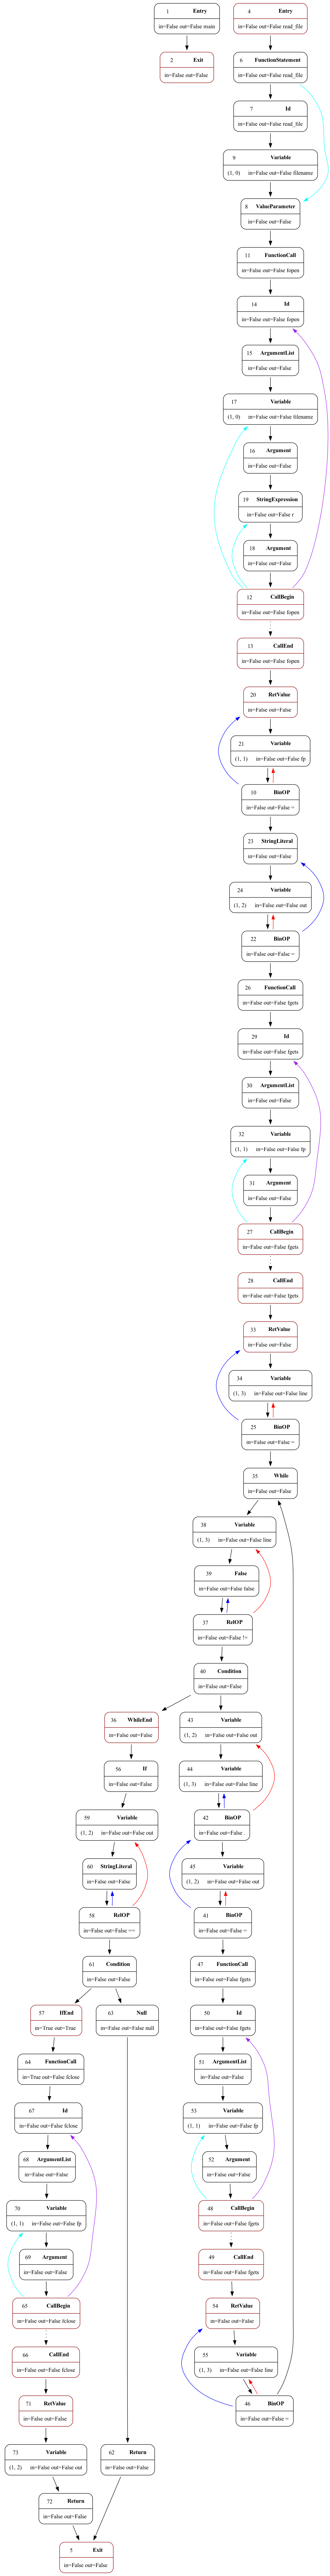

In [162]:
ptfa = DefinitelyReachablePTFA(
    lambda cfg, nid: cfg.get_type(nid) == "FunctionCall"
    and cfg.get_image(nid) == "fclose"
)
in_dict, out_dict = ptfa(cfg)
show_in_out(cfg, in_dict, out_dict)

In [163]:
unprotected = []

for nid in cfg.get_node_ids():
    if cfg.get_type(nid) == "FunctionCall" and cfg.get_image(nid) == "fopen":
        pos = cfg.get_position(cfg.get_children(nid)[0])
        protected = in_dict[nid]
        print(f"Line {pos[0]}:{pos[2]} has a fopen call which is {"correctly closed" if protected else "not closed"}")
        if not protected:
            unprotected.append(nid)

Line 4:9 has a fopen call which is not closed


Cette partie détecte bien que le `fclose` n'est pas forcément appelé. En effet, la fonction pourrait return avant l'appel au `fclose`.

### 2.2. Protections

On applique Definitely Reaching PTFA pour une recherche des vérifications de privilège :

In [5]:
cfg = cfg_reader.read_cfg("../tp/part_2/wp-db.php.cfg.json")

In [6]:
CHECK_NODES = [
    { "type": "Condition" },
    { "type": "RetValue" },
    { "type": "CallEnd", "image": "has_cap" },
    { "type": "CallBegin", "image": "has_cap" },
    { "type": "Argument" },
    { "type": "StringLiteral", "image": "use_db" },
    { "type": "ArgumentList" },
    { "type": "Id", "image": "has_cap" },
    { "type": "FunctionCall", "image": "has_cap" },
    { "type": "If" }
]


def check(cfg: CFG, nid: int) -> bool:
    for i, node in enumerate(CHECK_NODES):
        if cfg.get_type(nid) != node['type']:
            return False
        if "image" in node.keys() and cfg.get_image(nid) != node['image']:
            return False

        if node['type'] == "CallEnd":
            nid = cfg.get_call_begin(nid)
        else:
            parents = cfg.get_parents(nid)
            if i == len(CHECK_NODES) - 1:
                return True
            if len(parents) != 1:
                return False
            nid = parents[0]

    return True


ptfa = DefinitelyReachingPTFA(check)
in_dict, out_dict = ptfa(cfg)
annoted = show_in_out(cfg, in_dict, out_dict)

dot = annoted.to_dot()
s = Source(dot)
s.render("wp-db", format="pdf", cleanup=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.89476 to fit


'wp-db.pdf'

In [7]:
unprotected = []

for nid in cfg.get_node_ids():
    if cfg.get_type(nid) == "FunctionCall" and cfg.get_image(nid) == "mysql_query":
        pos = cfg.get_position(cfg.get_children(nid)[0])
        protected = in_dict[nid]
        print(f"Line {pos[0]}:{pos[2]} has a mysql_query call which is {"protected" if protected else "not protected"}")
        if not protected:
            unprotected.append(nid)

Line 743:6 has a mysql_query call which is protected
Line 752:7 has a mysql_query call which is not protected
Line 759:9 has a mysql_query call which is protected


Ici, on remarque que le 2e appel `mysql_query` est non-protégé, parce qu'il n'y a pas de vérification de privilèges réalisée auparavant. Le premier appel quant à lui est bien protégé. Le troisième est plus particulier et sera discuté au point 4, mais il est marqué "protégé" parce que pour l'atteindre il faut avoir rencontré auparavant la vérification.

## 3. Réparation automatique

In [8]:
with open("../tp/part_2/wp-db.php") as f:
    lines = f.readlines()
    for nid in unprotected:
        pos = cfg.get_position(cfg.get_children(nid)[0])
        line_pos = pos[0]
        col_pos = pos[2]

        lines.insert(line_pos - 1, f"{' ' * col_pos}if ( has_cap( 'use_db' ) )\n")
        # Re-indent the mysql_query line
        lines[line_pos] = f"  {lines[line_pos]}"

        print(f"Added protection to line {line_pos}")

    with open("../tp/part_2/wp-db-protected.php", "w") as f:
        f.write("".join(lines))
        print("File written to wp-db-protected.php")

Added protection to line 752
File written to wp-db-protected.php


Le fichier résultant est "wp-db-protected.php". Une ligne de vérification est ajoutée avant les appels qui ne sont pas vérifiés à coup sur.

## 4. Justifier

Le 3e cas de vérification de mysql_query n'est pas correctement vérifié. Une fois qu'on l'indente correctement, la fonction est la suivante :

```php
public function set_surname( $dbh, $user = null, $name = null) {
    if ( has_cap( 'use_db' ) )
        $query = $this->prepare( 'UPDATE users SET surname = %s WHERE user = %s', $name, $user );
    mysql_query( $query, $dbh );
}
```

On se rend compte qu'en réalité l'appel mysql_query n'est pas protégé. En effet, le PTFA va le considéré comme protégé parce qu'il est passé par un appel `if ( has_cap( 'use_db' ) )`, mais à aucun moment ceci nous certifie que la condition est `true` ou `false`. On sait qu'on est passé par ce noeud, mais on n'est toujours pas certain d'avoir les permissions.

Il faudrait donc ne propager le `true` que dans la branche de droite du graphe (la partie où la permission est valide).